Loading Data

In [1]:
import re

# Load the book's text
with open('data/TKMBFullBook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

Cleaing book by spliting the chapters

In [2]:
chapters = re.split(r'Chapter \d+', text)
if chapters[0].strip() == "":
    chapters.pop(0) # Remove the empty string before the first chapter

Tokenizing by sentences and chunking by paragraphs

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def sentence_chunks(text, tokenizer, max_tokens=450, overlap_tokens=60):
    """
    Greedy pack sentences into chunks under max_tokens using the model tokenizer.
    Adds a small sentence-level overlap between adjacent chunks using tokens.
    """
    sents = sent_tokenize(text)
    chunks = []
    current = []
    current_tokens = 0

    def tok_len(t):
        return len(tokenizer.tokenize(t))

    i = 0
    while i < len(sents):
        s = sents[i]
        s_tokens = tok_len(s)
        if s_tokens > max_tokens:
            # Very long sentence: hard split by words as a rare fallback
            words = s.split()
            # keep ~max_tokens-10 tokens margin when splitting
            step = max(1, int(len(words) * (max_tokens / (s_tokens + 1e-9))))
            for wstart in range(0, len(words), step):
                piece = " ".join(words[wstart:wstart+step])
                chunks.append(piece)
            i += 1
            current, current_tokens = [], 0
            continue

        if current_tokens + s_tokens <= max_tokens:
            current.append(s)
            current_tokens += s_tokens
            i += 1
        else:
            # finalize current chunk
            if current:
                chunk_text = " ".join(current)
                chunks.append(chunk_text)

                # build overlap buffer from the end of current
                if overlap_tokens > 0:
                    back = []
                    back_tokens = 0
                    for sent in reversed(current):
                        tl = tok_len(sent)
                        if back_tokens + tl > overlap_tokens:
                            break
                        back.append(sent)
                        back_tokens += tl
                    current = list(reversed(back))
                    current_tokens = sum(tok_len(x) for x in current)
                else:
                    current, current_tokens = [], 0
            else:
                # edge case: single sentence larger than budget handled above
                i += 1

    if current:
        chunks.append(" ".join(current))

    return chunks


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initializing sentence transformer

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')
tokenizer = model.tokenizer

W0901 11:07:08.835000 44608 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Tokenizing using sententence trnsformer tokenizer

In [5]:
all_chunks = []
for chap_num, chap_text in enumerate(chapters, start=1):
    for i, chunk in enumerate(sentence_chunks(chap_text, tokenizer,
                                              max_tokens=450, overlap_tokens=60), start=1):
        all_chunks.append({
            "chapter": chap_num,
            "chunk_id": f"{chap_num}_{i}",
            "text": chunk
        })

In [6]:
print(f"Total chunks created: {len(all_chunks)}")
print(f"Example chunk: {all_chunks[50]}")

Total chunks created: 369
Example chunk: {'chapter': 5, 'chunk_id': '5_1', 'text': '\n My nagging got the better of Jem eventually, as I knew it would, and to my relief \nwe slowed down the game for a while. He still maintained, however, that Atticus \nhadn’t said we couldn’t, therefore we could; and if Atticus ever said we couldn’t, \nJem had thought of a way around it: he would simply change the names of the \ncharacters and then we couldn’t be accused of playing anything. Dill was in hearty agreement with this plan of action. Dill was becoming \nsomething of a trial anyway, following Jem about. He had asked me earlier in the \nsummer to marry him, then he promptly forgot about it. He staked me out, marked \nas his property, said I was the only girl he would ever love, then he neglected me. I beat him up twice but it did no good, he only grew closer to Jem. They spent \ndays together in the treehouse plotting and planning, calling me only when they \nneeded a third party. But I kept 

Sentences per chunk analysis

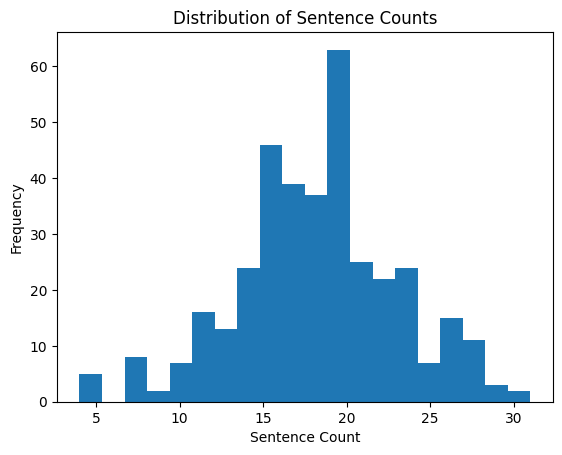

In [7]:
#plot the sentence per chunk
import matplotlib.pyplot as plt

sentence_counts = [len(sent_tokenize(chunk['text'])) for chunk in all_chunks]
plt.hist(sentence_counts, bins=20)
plt.xlabel('Sentence Count') # Number of sentences in each text chunk
plt.ylabel('Frequency') # Number of chunks with a given sentence count
plt.title('Distribution of Sentence Counts')
plt.show()

Creating Embeddings

In [8]:
texts = [chunk['text'] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_tensor=False, show_progress_bar=True, batch_size=32)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
embeddings[1]  # Example to show the embedding of the second chunk

array([-2.57084407e-02,  6.11791164e-02,  1.40771829e-03,  1.75060723e-05,
       -3.98007333e-02,  1.92359816e-02, -1.53717324e-02, -8.10483098e-03,
        1.40671153e-02, -2.97832191e-02,  8.98269285e-03,  7.66535178e-02,
        6.14860393e-02, -5.38585596e-02, -2.29360051e-02,  4.69067059e-02,
       -2.75505371e-02,  4.83390950e-02,  3.67982350e-02,  1.01526929e-02,
       -2.65493859e-02,  4.19890098e-02,  2.33274307e-02, -2.60379110e-02,
        2.98224483e-02, -7.44916219e-03,  8.91691260e-03,  3.84011082e-02,
       -4.92018536e-02, -1.33131891e-02, -7.92668760e-03,  8.66289530e-03,
       -1.41528379e-02, -3.42739448e-02,  2.10065696e-06,  1.27481902e-02,
        2.46044155e-02, -2.07386054e-02, -2.75453031e-02,  3.72424237e-02,
        6.75441101e-02,  2.17401795e-02,  1.97675619e-02,  1.94610003e-02,
       -5.75919561e-02,  9.86258406e-03, -5.01122251e-02,  1.19426530e-02,
       -2.92861033e-02,  8.20831489e-03,  6.88517559e-03,  1.28594544e-02,
        2.61526760e-02,  

In [10]:
embeddings.shape

(369, 768)

Indexing With FAISS (Facebook AI Similarity Search) on chunk/Paragraph level

In [11]:
import faiss
import numpy as np

# Convert to float32 ( required for FAISS)
embedding_matrix = np.array(embeddings).astype('float32')

# Build index (using cosine)
dimension = embedding_matrix.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product = Cosine similarity (after normalization)

# Normalize for cosine similarity
faiss.normalize_L2(embedding_matrix)

# Add vectors
index.add(embedding_matrix)

In [12]:
def search_faiss(query, top_k=5):
    # Encode and normalize query
    query_vec = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(query_vec)

    # Search index
    scores, indices = index.search(query_vec, top_k)

    # Retrieve the corresponding chunks
    results = []
    for i, score in zip(indices[0], scores[0]):
        result = {
            "chunk_id": all_chunks[i]["chunk_id"],
            "chapter": all_chunks[i]["chapter"],
            "text": all_chunks[i]["text"],
            "score": float(score)
        }
        results.append(result)
    
    return results


Calling OpenAPI GPT model for text generation

In [13]:
import openai
from openai import OpenAI
import os

#  OpenAI API key

client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY")) #Using environmental variable

#generate text
def generate_text(prompt: str) -> str:
    """Generates text using the OpenAI API based on the provided prompt."""
    
    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  
        messages=[{"role": "system", "content": "You are a creative short story writer who writes stories in a specified book/novel style and answer questions based on it."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,  # Adjust temperature for creativity
    )
    
    return response.choices[0].message.content.strip()

In [43]:
generated_text = generate_text("In the novel 'To Kill a Mockingbird' How was jem injured?")
print(generated_text)


In Harper Lee's novel *To Kill a Mockingbird*, Jem Finch is injured towards the end of the story during an attack by Bob Ewell. After the Halloween pageant at the school, Jem and his sister Scout are walking home when Bob Ewell ambushes them in a dark, wooded area. During the struggle, Jem is badly hurt, sustaining a broken arm. He is later cared for by his father, Atticus Finch, and their neighbor, Boo Radley, who intervenes and saves the children from further harm. This incident is a pivotal moment in the novel, highlighting the themes of courage and the loss of innocence.


Ranking with FAISS

In [44]:
query = generated_text
top_results = search_faiss(query, top_k=10)

for res in top_results:
    print(f"Chapter {res['chapter']} | Chunk {res['chunk_id']} | Score: {res['score']:.3f}")
    print(res['text'])
    print("---")


Chapter 30 | Chunk 30_4 | Score: 0.699
“You said Jem yanked Mr. Ewell off you?”
 “Yes sir, that’s what I thought… I—”
 “See there, Heck? Thank you from the bottom of my heart, but I don’t want my 
boy starting out with something like this over his head. Best way to clear the air is 
to have it all out in the open. Let the county come and bring sandwiches. I don’t 
want him growing up with a whisper about him, I don’t want anybody saying, 
‘Jem Finch… his daddy paid a mint to get him out of that.’ Sooner we get this 
over with the better.”
 “Mr. Finch,” Mr. Tate said stolidly, “Bob Ewell fell on his knife. He killed 
himself.”
 Atticus walked to the corner of the porch. He looked at the wisteria vine. In his 
own way, I thought, each was as stubborn as the other. I wondered who would 
give in first. Atticus’s stubbornness was quiet and rarely evident, but in some 
ways he was as set as the Cunninghams. Mr. Tate’s was unschooled and blunt, but 
it was equal to my father’s. “Heck,” Atticu

Calculating Retrieval Metrics on FAISS on Paragraph level

In [45]:
#calculate precision at k
def calculate_precision_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / k if k > 0 else 0.0

#calculate recall at k
def calculate_recall_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / len(relevant_set) if relevant_set else 0.0

#calculate f1 score at k
def calculate_f1_at_k(retrieved, relevant, k):
    precision = calculate_precision_at_k(retrieved, relevant, k)
    recall = calculate_recall_at_k(retrieved, relevant, k)
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    return 0.0

#calculate MRR
def calculate_mrr(retrieved, relevant):
    mrr = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            mrr = 1 / (i + 1)
            break
    return mrr

#Calculate nDCG
def calculate_ndcg(retrieved, relevant):
    dcg = 0.0
    idcg = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            dcg += 1 / (np.log2(i + 2))
    for i, doc in enumerate(relevant):
        idcg += 1 / (np.log2(i + 2))
    return dcg / idcg if idcg > 0 else 0.0

#calculate accuracy
def calculate_accuracy(retrieved, relevant):
    relevant_set = set(relevant)
    num_correct = sum(1 for doc in retrieved if doc in relevant_set)
    return num_correct / len(relevant_set) if relevant_set else 0.0

def calculate_map(retrieved, relevant):
    return sum(calculate_precision_at_k(retrieved, relevant, k) for k in [1, 5, 10]) / 3

relevant_docs = {"1_1","7_1", "9_18", "12_1", "28_15","10_1", "26_8", "30_4", "11_8", "15_11"}  # relevant doc ids for a single query
retrieved_docs = [r["chunk_id"] for r in top_results]  # retrieved doc ids from the search results

#relevant_docs = {"1","7", "9", "10", "11","12","15","26","28","30"}
#use the chapter number as the retrieved doc id
#retrieved_docs = [r["chapter"] for r in top_results]  # retrieved doc ids from the search results
print("Precision at k5:", calculate_precision_at_k(retrieved_docs, relevant_docs, k=5))
print("Precision at k10:", calculate_precision_at_k(retrieved_docs, relevant_docs, k=10))

print("Recall at k5:", calculate_recall_at_k(retrieved_docs, relevant_docs, k=5))
print("Recall at k10:", calculate_recall_at_k(retrieved_docs, relevant_docs, k=10))

print("F1 at k5:", calculate_f1_at_k(retrieved_docs, relevant_docs, k=5))
print("F1 at k10:", calculate_f1_at_k(retrieved_docs, relevant_docs, k=10))

print("MAP:", calculate_map(retrieved_docs, relevant_docs))
print("MRR:", calculate_mrr(retrieved_docs, relevant_docs))
print("nDCG:", calculate_ndcg(retrieved_docs, relevant_docs))
print("Accuracy:", calculate_accuracy(retrieved_docs, relevant_docs))

Precision at k5: 0.2
Precision at k10: 0.2
Recall at k5: 0.1
Recall at k10: 0.2
F1 at k5: 0.13333333333333333
F1 at k10: 0.20000000000000004
MAP: 0.4666666666666666
MRR: 1.0
nDCG: 0.2934556883974402
Accuracy: 0.2


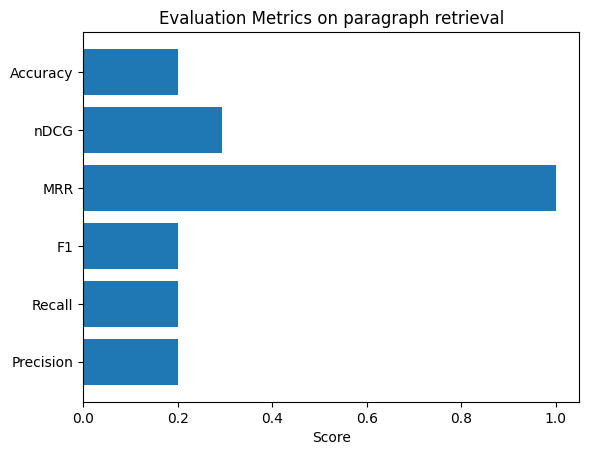

In [46]:
#plot the results
import matplotlib.pyplot as plt

metrics = {
    "Precision": calculate_precision_at_k(retrieved_docs, relevant_docs, k=10),
    "Recall": calculate_recall_at_k(retrieved_docs, relevant_docs, k=10),
    "F1": calculate_f1_at_k(retrieved_docs, relevant_docs, k=10),
    "MRR": calculate_mrr(retrieved_docs, relevant_docs),
    "nDCG": calculate_ndcg(retrieved_docs, relevant_docs),
    "Accuracy": calculate_accuracy(retrieved_docs, relevant_docs)
}

plt.barh(list(metrics.keys()), list(metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics on paragraph retrieval")
plt.show()


Plotting precison against recall

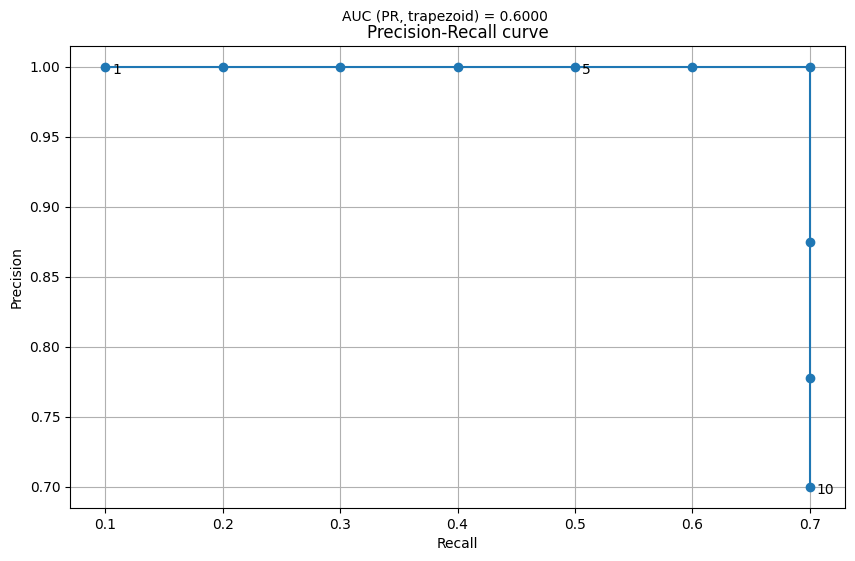

k	Precision	Recall
1	1.0000	0.1000
2	1.0000	0.2000
3	1.0000	0.3000
4	1.0000	0.4000
5	1.0000	0.5000
6	1.0000	0.6000
7	1.0000	0.7000
8	0.8750	0.7000
9	0.7778	0.7000
10	0.7000	0.7000


In [ ]:
# Plot precision vs recall curve for the current retrieval results
# Uses paragraph-level vars (retrieved_docs, relevant_docs) if present,
# otherwise falls back to chapter-level (predicted, gold_chapters).
import matplotlib.pyplot as plt
import numpy as np

# Choose available retrieval / relevance pair
if 'retrieved_docs' in globals() and 'relevant_docs' in globals():
    retrieved = list(retrieved_docs)
    relevant = set(relevant_docs)
    prec_fn = lambda r, k: calculate_precision_at_k(r, relevant, k)
    rec_fn = lambda r, k: calculate_recall_at_k(r, relevant, k)
elif 'predicted' in globals() and 'gold_chapters' in globals():
    retrieved = list(predicted)
    relevant = set(gold_chapters)
    # use chapter-level helpers defined earlier
    prec_fn = lambda r, k: precisionatk(r, relevant, k)
    rec_fn = lambda r, k: recallatk(r, relevant, k)
else:
    print('No suitable variables found for plotting (expected retrieved_docs/relevant_docs or predicted/gold_chapters).')
    retrieved = []
    relevant = set()
    prec_fn = lambda r, k: 0.0
    rec_fn = lambda r, k: 0.0

if not retrieved:
    print('No retrieved items to plot.')
else:
    max_k = min( max(1, len(retrieved)), 100 )
    ks = list(range(1, max_k + 1))
    precisions = [prec_fn(retrieved, k) for k in ks]
    recalls = [rec_fn(retrieved, k) for k in ks]

    # Ensure the recall values are non-decreasing for AUC computation
    # (precision@k/recall@k are defined per cutoff; plotted  directly)
    plt.figure(figsize=(10,6))
    plt.plot(recalls, precisions, marker='o', linestyle='-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.grid(True)

    # Annotate common cutoffs
    annotate_ks = {1,5,10,20}
    for i,k in enumerate(ks):
        if k in annotate_ks or k == ks[-1]:
            plt.annotate(str(k), (recalls[i], precisions[i]), textcoords='offset points', xytext=(5,-5))

    # estimate area under PR curve using trapezoidal rule
    try:
        auc_pr = np.trapz(precisions, recalls)
    except Exception:
        auc_pr = 0.0

    plt.suptitle(f'AUC (PR, trapezoid) = {auc_pr:.4f}', fontsize=10, y=0.94)
    plt.show()

    # Print a small table of values for quick inspection
    print('k	Precision	Recall')
    for k, p, r in zip(ks[:10], precisions[:10], recalls[:10]):
        print(f'{k}	{p:.4f}	{r:.4f}')

Retrieving on chapter level

In [47]:
from collections import defaultdict
import numpy as np
import faiss

def search_faiss_grouped(
    query: str,
    topN_chunks: int = 100,     # how many chunks to pull from FAISS
    top_chapters: int = 10,      # how many chapters to return
    per_chapter: int = 3,        # how many top chunks to keep per chapter
    agg: str = "max"             # chapter score: "max" or "mean" of its chunk scores
):
    """
    FAISS-only retrieval grouped by chapter.
    Returns a list of 'cards' sorted by chapter_score desc:
      [{
         'chapter': <int>,
         'chapter_score': <float>,
         'chunks': [
             {'chunk_id': str, 'chapter': int, 'text': str, 'retrieval_score': float}, ...
         ]
      }, ...]
    """
    # 1) Encode + normalize query (cosine via IP on L2-normalized vectors)
    q = model.encode([query], convert_to_numpy=True)  # SentenceTransformer
    faiss.normalize_L2(q)

    # 2) Retrieve topN chunks
    scores, idxs = index.search(q, topN_chunks)

    # 3) Build candidate list
    candidates = []
    for j, i in enumerate(idxs[0]):
        candidates.append({
            "chunk_id":        all_chunks[i]["chunk_id"],
            "chapter":         all_chunks[i]["chapter"],
            "text":            all_chunks[i]["text"],
            "retrieval_score": float(scores[0][j]),
            "_idx":            int(i)
        })

    if not candidates:
        return []

    # 4) Group by chapter
    buckets = defaultdict(list)
    for c in candidates:
        buckets[c["chapter"]].append(c)

    # 5) Score chapters + keep top chunks per chapter
    cards = []
    for chap, items in buckets.items():
        # sort chunks within chapter by retrieval score
        items.sort(key=lambda x: x["retrieval_score"], reverse=True)
        if agg == "mean":
            chapter_score = float(np.mean([x["retrieval_score"] for x in items]))
        else:  # "max" (default)
            chapter_score = float(items[0]["retrieval_score"])
        cards.append({
            "chapter": chap,
            "chapter_score": chapter_score,
            "chunks": items[:per_chapter]
        })

    # 6) Sort chapters + return top_chapters
    cards.sort(key=lambda x: x["chapter_score"], reverse=True)
    return cards[:top_chapters]

In [48]:
chapter_results = search_faiss_grouped(generated_text, topN_chunks=100, top_chapters=10, per_chapter=3, agg="max")
chapter_results

[{'chapter': 30,
  'chapter_score': 0.6987206935882568,
  'chunks': [{'chunk_id': '30_4',
    'chapter': 30,
    'text': '“You said Jem yanked Mr. Ewell off you?”\n “Yes sir, that’s what I thought… I—”\n “See there, Heck? Thank you from the bottom of my heart, but I don’t want my \nboy starting out with something like this over his head. Best way to clear the air is \nto have it all out in the open. Let the county come and bring sandwiches. I don’t \nwant him growing up with a whisper about him, I don’t want anybody saying, \n‘Jem Finch… his daddy paid a mint to get him out of that.’ Sooner we get this \nover with the better.”\n “Mr. Finch,” Mr. Tate said stolidly, “Bob Ewell fell on his knife. He killed \nhimself.”\n Atticus walked to the corner of the porch. He looked at the wisteria vine. In his \nown way, I thought, each was as stubborn as the other. I wondered who would \ngive in first. Atticus’s stubbornness was quiet and rarely evident, but in some \nways he was as set as the Cu

Calculating Chapter level metrics

In [49]:
from typing import List, Set
import math

#evaluate after rerank
def precisionatk(ranked: List[str], gold: Set[str], k: int) -> float:
    if k == 0:
        return 0.0
    preds = set(ranked[:k])
    return len(preds & gold) / len(preds) if preds else 0.0

def recallatk(ranked: List[str], gold: Set[str], k: int) -> float:
    if k == 0 or not gold:
        return 0.0
    preds = set(ranked[:k])
    return len(preds & gold) / len(gold)

def f1atk(ranked: List[str], gold: Set[str], k: int) -> float:
    p = precisionatk(ranked, gold, k)
    r = recallatk(ranked, gold, k)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def averageP(ranked: List[str], gold: Set[str], k: int) -> float:
    return sum(precisionatk(ranked, gold, i) for i in range(1, k + 1)) / k

def meanReciprocalRank(ranked: List[str], gold: Set[str]) -> float:
    for i, doc in enumerate(ranked):
        if doc in gold:
            return 1 / (i + 1)
    return 0.0

def ndcg(ranked: List[str], gold: Set[str], k: int) -> float:
    dcg = sum(1 / math.log2(i + 2) for i, doc in enumerate(ranked[:k]) if doc in gold)
    idcg = sum(1 / math.log2(i + 2) for i in range(len(gold)))
    return dcg / idcg if idcg > 0 else 0.0

def accuracy(ranked: List[str], gold: Set[str]) -> float:
    if not ranked:
        return 0.0
    return sum(1 for doc in ranked if doc in gold) / len(ranked)

ground_truth = {
    "query1": {"1","7", "9", "10", "11","12","15","26","28","30"},
    
}

# Flatten all chunk_ids from Rerank_results
#predicted = [chunk["chunk_id"] for card in Rerank_results for chunk in card["chunks"]] "26_8", "30_4", "11_8", "15_11

best_chapters = [c["chapter"] for c in chapter_results]
gold_chapters = {int(ch.split('_')[0]) for ch in ground_truth["query1"]}  # extract chapter numbers



#k = 10


#predicted = [card["chapter"] for card in Rerank_results]
#gold_chapters = {int(c.split('_')[0]) for c in ground_truth["query1"]}

print("precision@5:", precisionatk(best_chapters, gold_chapters, 5))
print("precision@10:", precisionatk(best_chapters, gold_chapters, 10))
print("recall@5:", recallatk(best_chapters, gold_chapters, 5))
print("recall@10:", recallatk(best_chapters, gold_chapters, 10))
print("F1@5:", f1atk(best_chapters, gold_chapters, 5))
print("F1@10:", f1atk(best_chapters, gold_chapters, 10))
print("MAP@5:", averageP(best_chapters, gold_chapters, 5))
print("MAP@10:", averageP(best_chapters, gold_chapters, 10))
print("MRR:", meanReciprocalRank(best_chapters, gold_chapters))
print("NDCG@5:", ndcg(best_chapters, gold_chapters, 5))
print("NDCG@10:", ndcg(best_chapters, gold_chapters, 10))
print("Accuracy:", accuracy(best_chapters, gold_chapters))

precision@5: 0.8
precision@10: 0.6
recall@5: 0.4
recall@10: 0.6
F1@5: 0.5333333333333333
F1@10: 0.6
MAP@5: 0.9099999999999999
MAP@10: 0.7878174603174602
MRR: 1.0
NDCG@5: 0.5541432109622958
NDCG@10: 0.696162268139923
Accuracy: 0.6


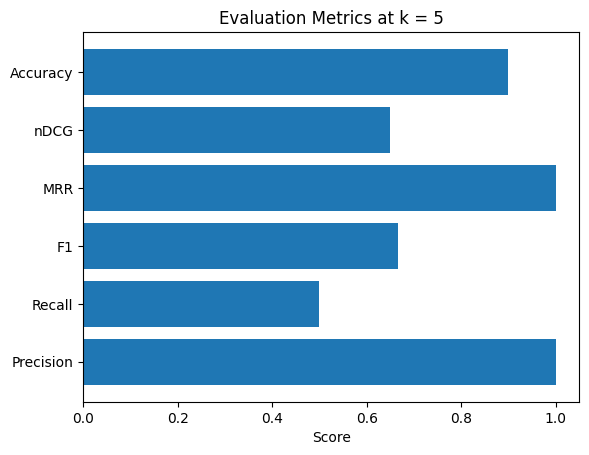

In [24]:
chapter_metrics = {
    "Precision": precisionatk(best_chapters, gold_chapters, 5),
    "Recall": recallatk(best_chapters, gold_chapters, 5),
    "F1": f1atk(best_chapters, gold_chapters, 5),
    "MRR": meanReciprocalRank(best_chapters, gold_chapters),
    "nDCG": ndcg(best_chapters, gold_chapters, 5),
    "Accuracy": accuracy(best_chapters, gold_chapters)
}

plt.barh(list(chapter_metrics.keys()), list(chapter_metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics at k = 5")
plt.show()

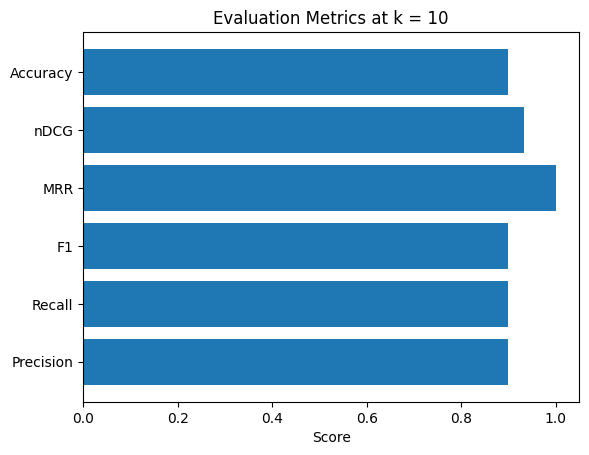

In [25]:
chapter_metrics = {
    "Precision": precisionatk(best_chapters, gold_chapters, 10),
    "Recall": recallatk(best_chapters, gold_chapters, 10),
    "F1": f1atk(best_chapters, gold_chapters, 10),
    "MRR": meanReciprocalRank(best_chapters, gold_chapters),
    "nDCG": ndcg(best_chapters, gold_chapters, 10),
    "Accuracy": accuracy(best_chapters, gold_chapters)
}

plt.barh(list(chapter_metrics.keys()), list(chapter_metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics at k = 10")
plt.show()

ReRanking With Cross Encoder

In [26]:
from sentence_transformers import CrossEncoder
_reranker = None

def get_reranker():
    global _reranker
    if _reranker is None:
        _reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    return _reranker

Reranking retrieved results

In [27]:
# Get the first chunk text for each chapter in chapter_results
chapter_texts = []
for chap in chapter_results:
    for chunk in all_chunks:
        if chunk["chapter"] == chap:
            chapter_texts.append(chunk["text"])
            break

reranker = get_reranker()
# Rerank based on both chapter and chunk relevance
chapter_chunk_pairs = []         # pairs for reranker
chapter_chunk_ids = []           # (chapter, chunk_id)
chapter_chunk_texts = []         # chunk texts aligned with ids

# collect candidate chunks from all chapters in best_chapters
TOP_CHUNKS_PER_CHAPTER = 10
for chap in best_chapters:
    relevant_chunks = [chunk for chunk in all_chunks if chunk["chapter"] == chap]
    for chunk in relevant_chunks[:TOP_CHUNKS_PER_CHAPTER]:
        chapter_chunk_pairs.append((generated_text, chunk["text"]))
        chapter_chunk_ids.append((chunk["chapter"], chunk["chunk_id"]))
        chapter_chunk_texts.append(chunk["text"])

# Score with reranker
if chapter_chunk_pairs:
    chunk_scores = reranker.predict(chapter_chunk_pairs, batch_size=32)
else:
    chunk_scores = []

# Build combined records aligned correctly
combined = []
for (chap, cid), text, score in zip(chapter_chunk_ids, chapter_chunk_texts, chunk_scores):
    combined.append({"chapter": int(chap), "chunk_id": cid, "text": text, "score": float(score)})

# 1) Global ranking across all chapters/chunks
combined_sorted = sorted(combined, key=lambda x: x["score"], reverse=True)

#print("Top ranked chunks (global):")
#for idx, item in enumerate(combined_sorted[:20], start=1):
    #print(f"Rank {idx} | Score: {item['score']:.4f} | Chapter: {item['chapter']} | Chunk: {item['chunk_id']}")
    #print(item['text'][:300] + ("..." if len(item['text']) > 300 else ""))
    #print("---")

# 2) Chapter-level aggregation (e.g., max chunk score per chapter)
from collections import defaultdict
chap_buckets = defaultdict(list)
for it in combined:
    chap_buckets[it['chapter']].append(it)

cards = []
PER_CHAPTER_KEEP = 3
for chap, items in chap_buckets.items():
    items.sort(key=lambda x: x['score'], reverse=True)
    chapter_score = items[0]['score'] if items else 0.0
    cards.append({
        'chapter': chap,
        'chapter_score': chapter_score,
        'chunks': items[:PER_CHAPTER_KEEP]
    })

cards.sort(key=lambda x: x['chapter_score'], reverse=True)

print('\nChapter-level ranking (aggregated from chunk scores):')
for i, c in enumerate(cards[:10], start=1):
    print(f"{i}. Chapter {c['chapter']} | Score: {c['chapter_score']:.4f} | top_chunks: {[ch['chunk_id'] for ch in c['chunks']]}")

# Provide variables for downstream cells 1","7", "9", "10", "11","12","15","26","28","30"
reranked_combined = combined_sorted
reranked_cards = cards



Chapter-level ranking (aggregated from chunk scores):
1. Chapter 11 | Score: -1.9963 | top_chunks: ['11_4', '11_2', '11_3']
2. Chapter 10 | Score: -2.4155 | top_chunks: ['10_2', '10_9', '10_1']
3. Chapter 7 | Score: -2.4283 | top_chunks: ['7_6', '7_1', '7_3']
4. Chapter 15 | Score: -2.4440 | top_chunks: ['15_10', '15_9', '15_7']
5. Chapter 30 | Score: -2.6174 | top_chunks: ['30_3', '30_6', '30_5']
6. Chapter 29 | Score: -2.7776 | top_chunks: ['29_4', '29_2', '29_5']
7. Chapter 9 | Score: -3.4824 | top_chunks: ['9_4', '9_7', '9_8']
8. Chapter 12 | Score: -3.5085 | top_chunks: ['12_3', '12_1', '12_2']
9. Chapter 28 | Score: -3.6742 | top_chunks: ['28_1', '28_3', '28_7']
10. Chapter 26 | Score: -4.4833 | top_chunks: ['26_7', '26_8', '26_1']


Reranking evaluation

In [28]:
#evaluate the performance of the reranking
best_reranked = [c["chapter"] for c in reranked_cards]
gold_chapters = {int(ch.split('_')[0]) for ch in ground_truth["query1"]}  # extract chapter numbers



print("precision@5:", precisionatk(best_reranked, gold_chapters, 5))
print("precision@10:", precisionatk(best_reranked, gold_chapters, 10))
print("recall@5:", recallatk(best_reranked, gold_chapters, 5))
print("recall@10:", recallatk(best_reranked, gold_chapters, 10))
print("F1@5:", f1atk(best_reranked, gold_chapters, 5))
print("F1@10:", f1atk(best_reranked, gold_chapters, 10))
print("MAP@5:", averageP(best_reranked, gold_chapters, 5))
print("MAP@10:", averageP(best_reranked, gold_chapters, 10))
print("MRR:", meanReciprocalRank(best_reranked, gold_chapters))
print("NDCG@5:", ndcg(best_reranked, gold_chapters, 5))
print("NDCG@10:", ndcg(best_reranked, gold_chapters, 10))
print("Accuracy:", accuracy(best_reranked, gold_chapters))

precision@5: 1.0
precision@10: 0.9
recall@5: 0.5
recall@10: 0.9
F1@5: 0.6666666666666666
F1@10: 0.9
MAP@5: 1.0
MAP@10: 0.9354365079365079
MRR: 1.0
NDCG@5: 0.6489315753318465
NDCG@10: 0.9216017310213247
Accuracy: 0.9


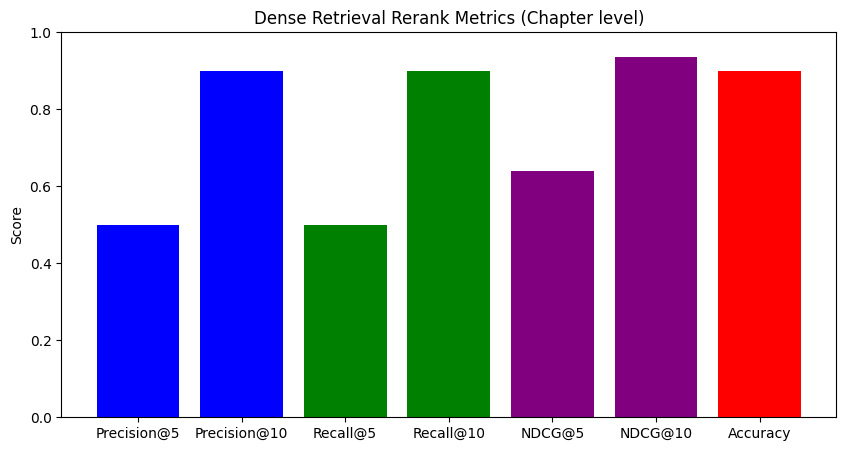

In [42]:
#plot rerank metrics e.g. precision, recall, F1-score
import matplotlib.pyplot as plt

# Use valid variable names
precision_5 = 0.5
precision_10 = 0.9
recall_5 = 0.5
recall_10 = 0.9
ndcg_5 = 0.64
ndcg_10 = 0.935
accuracy = 0.9

metrics = ['Precision@5', 'Precision@10', 'Recall@5', 'Recall@10', 'NDCG@5', 'NDCG@10', 'Accuracy']
values = [precision_5, precision_10, recall_5, recall_10, ndcg_5, ndcg_10, accuracy]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'blue', 'green', 'green', 'purple', 'purple', 'red'])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Dense Retrieval Rerank Metrics (Chapter level)")
plt.show()


Precision vs Recall and AUC for chapter level reranked results

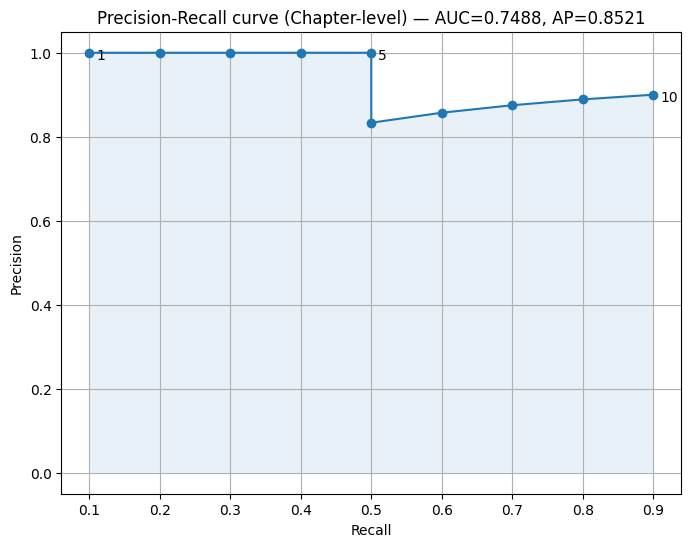

k	Precision	Recall
1	1.0000	0.1000
2	1.0000	0.2000
3	1.0000	0.3000
4	1.0000	0.4000
5	1.0000	0.5000
6	0.8333	0.5000
7	0.8571	0.6000
8	0.8750	0.7000
9	0.8889	0.8000
10	0.9000	0.9000
Average Precision (AP) = 0.852103
AUC (PR, trapezoid) = 0.748770


In [29]:
# Precision-Recall curve and AUC for chapter-level reranked results
import matplotlib.pyplot as plt
import numpy as np

# We expect `predicted` (ranked chapter ints) and `gold_chapters` (set of relevant chapter ints) to exist
if 'best_reranked' not in globals() or 'gold_chapters' not in globals():
    print('Variables `predicted` and `gold_chapters` not found. Run reranking cells first.')
else:
    retrieved = list(best_reranked)
    relevant = set(gold_chapters)

    if not retrieved:
        print('No retrieved chapters to evaluate.')
    else:
        max_k = len(retrieved)
        ks = list(range(1, max_k + 1))
        precisions = [precisionatk(best_reranked, relevant, k) for k in ks]
        recalls = [recallatk(best_reranked, relevant, k) for k in ks]

        # Compute AUC for PR curve (trapezoidal on recall axis). Ensure monotonic recall for area calc isn't strictly required here
        try:
            auc_pr = np.trapz(precisions, recalls)
        except Exception:
            auc_pr = 0.0

        # Compute Average Precision (AP) -- sum precision@k for relevant hits divided by number of relevant docs
        num_relevant = len(relevant)
        if num_relevant > 0:
            ap_sum = 0.0
            hit_count = 0
            for k in ks:
                if best_reranked[k-1] in relevant:
                    hit_count += 1
                    ap_sum += precisionatk(best_reranked, relevant, k)
            average_precision = ap_sum / num_relevant
        else:
            average_precision = 0.0

        # Plot PR curve
        plt.figure(figsize=(8,6))
        plt.plot(recalls, precisions, marker='o', linestyle='-')
        plt.fill_between(recalls, precisions, alpha=0.1)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall curve (Chapter-level) — AUC={auc_pr:.4f}, AP={average_precision:.4f}')
        plt.grid(True)

        # Annotate a few cutoffs
        annotate_ks = {1,5,10}
        for i,k in enumerate(ks):
            if k in annotate_ks or k == ks[-1]:
                plt.annotate(str(k), (recalls[i], precisions[i]), textcoords='offset points', xytext=(5,-5))

        plt.show()

        # Print summary table for first 20 cutoffs
        print('k	Precision	Recall')
        for k, p, r in zip(ks[:20], precisions[:20], recalls[:20]):
            print(f'{k}	{p:.4f}	{r:.4f}')

        #print(f'

        print(f'Average Precision (AP) = {average_precision:.6f}')
        print(f'AUC (PR, trapezoid) = {auc_pr:.6f}')